## ETL e seus desafios 
#### Hands on 4
Luca Mantovani Poit


<img src="azure.png" alt="drawing" width="200"/>

Importando o necessário

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
import pyodbc
from io import BytesIO
import os
import json


In [ ]:
# importando para fazer a conexão com blob storage 
from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient
from azure.keyvault.secrets import SecretClient

Fazendo a conexão com a Azure usando as credenciais guardadas no key vault

In [3]:
KEY_VAULT_URL = "https://kv-academy-01.vault.azure.net/"
credential = DefaultAzureCredential()
client = SecretClient(vault_url=KEY_VAULT_URL, credential=credential)

#nome do segredo que queremos pegar
secret_blob_name = 'stg-academy-nome'

#pegando o segredo correspodente
retrieved_blob_secret = client.get_secret(secret_blob_name)

In [4]:
#Guardando todas as credenciais necessárias para montar os links de acesso no futuro
SERVER = client.get_secret("db-academy-server")
DATABASE = client.get_secret("db-academy-database")
USERNAME = client.get_secret("db-academy-user")
PASSWORD = client.get_secret("db-academy-password")
DRIVER='ODBC Driver 18 for SQL Server'

In [5]:
#função da documentação
def get_blob_service_client_token_credential():
    
    #montando a url usando o segredo, note o .value para pegar o valor e nao o objeto
    account_url = "https://" + retrieved_blob_secret.value + ".blob.core.windows.net"

    #validando a credencial
    credential = DefaultAzureCredential()

    #Criando o objeto BlobServiceClient
    blob_service_client = BlobServiceClient(account_url, credential=credential)

    #retornando o objeto
    return blob_service_client


#instanciando um objeto usando a função
blob_service_client = get_blob_service_client_token_credential()

#uma ação qualquer para mostrar que a conexão foi feita
for container in blob_service_client.list_containers():
    print(container.name)

academy-teste
azure-webjobs-hosts
azure-webjobs-secrets
yelpinc


Acessando o container específico com os arquivos que queremos trabalhar

In [6]:
container_name="yelpinc"
container_client = blob_service_client.get_container_client(container_name)

Iterando para ver quais arquivos estão disponíveis

In [7]:
for blob in container_client.list_blob_names():
    print(blob)

yelp_academic_dataset_business.json
yelp_academic_dataset_checkin.json
yelp_academic_dataset_review.json
yelp_academic_dataset_tip.json
yelp_academic_dataset_user.json


Função que permite 'espiar' cada um dos arquivos para entender melhor como proceder com a execução das tarefas

In [7]:
for blob in container_client.list_blob_names():

    filename = blob
    blob_client = container_client.get_blob_client(filename)

    print(f'\n\nnome do arquivo: {blob}\n\n')

    snippet_size=1024

    blob_data = blob_client.download_blob(0, snippet_size)
    snippet = blob_data.readall().decode('utf-8')
    snippet = json.loads(json.dumps(snippet))
    print(snippet)



nome do arquivo: yelp_academic_dataset_business.json


{"business_id":"Pns2l4eNsfO8kk83dixA6A","name":"Abby Rappoport, LAC, CMQ","address":"1616 Chapala St, Ste 2","city":"Santa Barbara","state":"CA","postal_code":"93101","latitude":34.4266787,"longitude":-119.7111968,"stars":5.0,"review_count":7,"is_open":0,"attributes":{"ByAppointmentOnly":"True"},"categories":"Doctors, Traditional Chinese Medicine, Naturopathic\/Holistic, Acupuncture, Health & Medical, Nutritionists","hours":null}
{"business_id":"mpf3x-BjTdTEA3yCZrAYPw","name":"The UPS Store","address":"87 Grasso Plaza Shopping Center","city":"Affton","state":"MO","postal_code":"63123","latitude":38.551126,"longitude":-90.335695,"stars":3.0,"review_count":15,"is_open":1,"attributes":{"BusinessAcceptsCreditCards":"True"},"categories":"Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services","hours":{"Monday":"0:0-0:0","Tuesday":"8:0-18:30","Wednesday":"8:0-18:30","Thursday":"8:0-18:30","Friday":"8:0-18:30","S

#### Aqui vamos popular uma tabela sem salvar o arquivo localmente

Um dos arquivos que queremos usar para popular a tabela é muito grande (>5gb). Para continuarmos, usamos o método chunks, que nos permite acessar pedaços da tabela e realizar operações nesses pedaços ao invés de acessar e transformar a tabela toda de uma vez. 

In [8]:
def populate_table(engine, stream_downloader, table_name):
    # buffer para armazenar a parte do arquivo que estamos lendo, será esvaziado cada vez que subirmos seu conteúdo para a tabela
    buffer = ""

    for chunk in stream_downloader.chunks():
        # Converte os chunks de bytes para string
        buffer += chunk.decode('utf-8', errors='ignore')

        # Usa a função split_lines para que cada linha seja um elemento da lista. Isso garante uma maneira para testar se temos
        # um JSON valido para subir para a tabela
        lines = buffer.splitlines()

        complete_lines = []
        
        for line in lines:
            try:
                # Verifica se a linha é um JSON válido
                json.loads(line)  
                complete_lines.append(line)  # Se sim, append na lista de linhas completas
            except json.JSONDecodeError:
                # Se não, deixa a linha no buffer e sai do bloco for
                buffer = line  
                break
        else:
            # Se todas as linhas forem completas, limpa o buffer
            buffer = ""

        if complete_lines:
            # Se tem linhas completas na nossa lista, join e passa para o pandas, para processar e popular a tabela com a estrutura de colunas correta
            complete_json = '\n'.join(complete_lines)
            try:
                data_chunk = pd.read_json(BytesIO(complete_json.encode('utf-8')), lines=True)
                data_chunk.to_sql(table_name, con=engine, if_exists='append', index=False)
            except ValueError as e:
                print("Error parsing JSON with pandas:", e)



In [9]:
connection_string = f'mssql+pyodbc://{USERNAME.value}:{PASSWORD.value}@{SERVER.value}/{DATABASE.value}?driver={DRIVER}'
engine = create_engine(connection_string)

In [17]:
blob_client = container_client.get_blob_client('yelp_academic_dataset_checkin.json')
#Fazer o download (o arquivo não fica salvo na máquina quando a sessão termina)
stream_downloader = blob_client.download_blob()

populate_table(engine, stream_downloader, 'luca_poit_checkin')

In [ ]:
blob_client = container_client.get_blob_client('yelp_academic_dataset_review.json')
stream_downloader = blob_client.download_blob()

populate_table(engine, stream_downloader, 'luca_poit_review')

In [ ]:
blob_client = container_client.get_blob_client('yelp_academic_dataset_user.json')
stream_downloader = blob_client.download_blob()

populate_table(engine, stream_downloader, 'luca_poit_user')

In [ ]:
# para a tabela business, um tratamento especial foi necessário, graças a presença de dicionários como valores 
blob_client = container_client.get_blob_client('yelp_academic_dataset_business.json')
stream_downloader = blob_client.download_blob()

df = pd.read_json(stream_downloader, lines=True)

#usando a função json.dumps para que os dicionários sejam transformados em strings
df['attributes'] = df['attributes'].apply(json.dumps)
df['hours'] = df['hours'].apply(lambda x: json.dumps(x) if not None else None)

df.to_sql('luca_poit_business', con=engine, if_exists='append', index=False)

#### Populando uma tabela através de um arquivo baixado:

In [18]:
# acessando o arquivo local
filepath = 'C:\\Users\\BlueShift\\Desktop\\Eng Dados\\Hands_on_4\\yelp_academic_dataset_tip.json'

In [10]:
# Criando uma conexão com a database usando o pyodbc
connectionString = f'DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={SERVER.value};DATABASE={DATABASE.value};UID={USERNAME.value};PWD={PASSWORD.value}'
conn = pyodbc.connect(connectionString) 
conn

Podemos executar queries SQL usando a conexão pyodbc

In [20]:
SQL_QUERY = """
CREATE TABLE luca_poit_tip (
    user_id VARCHAR(50) NOT NULL,
    business_id VARCHAR(50) NOT NULL,
    text VARCHAR(MAX) NULL,
    date DATETIME NULL,
    compliment_count INT NULL
);

"""

In [21]:
cursor = conn.cursor()
cursor.execute(SQL_QUERY)

Lendo o JSON com pandas

In [23]:
df = pd.read_json(filepath, lines=True)

In [ ]:
connection_string = f'mssql+pyodbc://{USERNAME.value}:{PASSWORD.value}@{SERVER.value}/{DATABASE.value}?driver={DRIVER}'
engine = create_engine(connection_string)


#subindo as colunas direto para a tabela no DB
df.to_sql('luca_poit_tip', con=engine, if_exists='append', index=False)

In [20]:
# testando a conexão
with engine.connect() as connection:
    result = connection.execute(text("SELECT TOP 5 * FROM luca_poit_tip;"))
    for row in result:
        print(row)

('AGNUgVwnZUey3gcPCJ76iw', '3uLgwr0qeCNMjKenHJwPGQ', 'Avengers time with the ladies.', datetime.datetime(2012, 5, 18, 2, 17, 21), 0)
('NBN4MgHP9D3cw--SnauTkA', 'QoezRbYQncpRqyrLH6Iqjg', 'They have lots of good deserts and tasty cuban sandwiches', datetime.datetime(2013, 2, 5, 18, 35, 10), 0)
('-copOvldyKh1qr-vzkDEvw', 'MYoRNLb5chwjQe3c_k37Gg', "It's open even when you think it isn't", datetime.datetime(2013, 8, 18, 0, 56, 8), 0)
('FjMQVZjSqY8syIO-53KFKw', 'hV-bABTK-glh5wj31ps_Jw', 'Very decent fried chicken', datetime.datetime(2017, 6, 27, 23, 5, 38), 0)
('ld0AperBXk1h6UbqmM80zw', '_uN0OudeJ3Zl_tf6nxg5ww', 'Appetizers.. platter special for lunch', datetime.datetime(2012, 10, 6, 19, 43, 9), 0)


## Fazendo análises com tabelas disponíveis no banco de dados

Para distribuir o uso de recursos da Azure e evitar crashs desnecessários, fiz as análises com tabelas que já estavam disponíveis no db. As minhas estão subindo depois da entrega do notebook

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
cursor = conn.cursor()

query = '''
SELECT TOP 10 COUNT(*) AS review_count, name FROM jonnathan_costa_review jcr 
LEFT JOIN jonnathan_costa_business jcb 
ON jcr.business_id = jcb.business_id 
GROUP BY jcb.name ORDER BY review_count DESC;

'''
# Executa a query
cursor.execute(query)

# Busca os resultados da query
rows = cursor.fetchall()

# pega o nome das colunas
columns = [column[0] for column in cursor.description]

# Converte os resultados para um DataFrame
top_10_most_reviewed = pd.DataFrame.from_records(rows, columns=columns)

#### Agrupando os reviews por empresa

Ao agrupar os reviews por empresa, conseguimos obter as top 10 empresas mais avaliadas. Segue de uma análise do arquivo, que uma mesma empresa pode ter diversos business_ID, provavelmente graças a presença de empresas grandes com varias franquias.

In [9]:
top_10_most_reviewed.head(10)

,review_count,name
0,21615,Starbucks
1,18234,McDonald's
2,10326,Dunkin'
3,9788,Chipotle Mexican Grill
4,9323,First Watch
5,8653,Taco Bell
6,8491,Acme Oyster House
7,8435,Chick-fil-A
8,7590,Panera Bread
9,7516,Oceana Grill


[None, None, None, None, None, None, None, None, None, None]

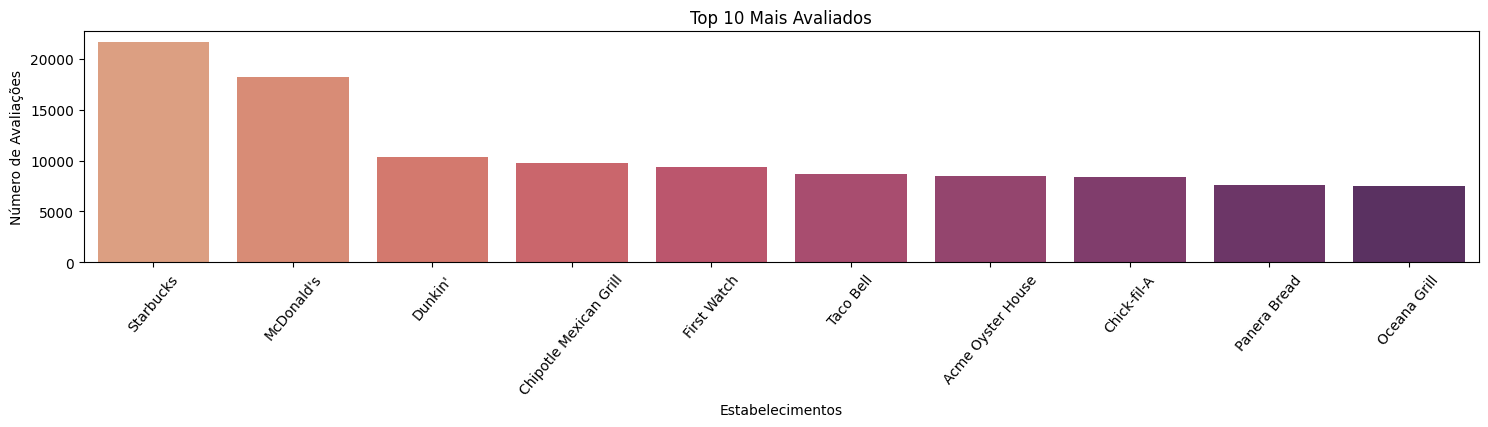

In [22]:
plt.figure(figsize=(18,3))
plot = sns.barplot(data=top_10_most_reviewed, x='name', y='review_count', hue='name', palette='flare')
plt.title('Top 10 Mais Avaliados')
plt.xlabel('Estabelecimentos')
plt.ylabel('Número de Avaliações')
plt.setp(plot.get_xticklabels(), rotation=50)

Vemos que de fato as empresas grandes possuem mais reviews, consequência de um fluxo maior de clientes quando consideradas todas as franquias. 

### Agrupando os reviews por ano

Ao agrupar os reviews por ano, obtemos uma visão da evolução temporal do número de reviews.

In [14]:
connectionString = f'DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={SERVER.value};DATABASE={DATABASE.value};UID={USERNAME.value};PWD={PASSWORD.value}'
conn = pyodbc.connect(connectionString) 

cursor = conn.cursor()

query = '''
SELECT COUNT(*) AS reviews_count, YEAR(date) AS date_year 
FROM jonnathan_costa_review jcr 
GROUP BY YEAR(date) 
ORDER BY YEAR(date) ASC;

'''
cursor.execute(query)

rows = cursor.fetchall()

columns = [column[0] for column in cursor.description]

reviews_by_year = pd.DataFrame.from_records(rows, columns=columns)

In [15]:
reviews_by_year.head(20)

,reviews_count,date_year
0,894,2005
1,3876,2006
2,15411,2007
3,48417,2008
4,74632,2009
5,139036,2010
6,231617,2011
7,287704,2012
8,385509,2013
9,524220,2014


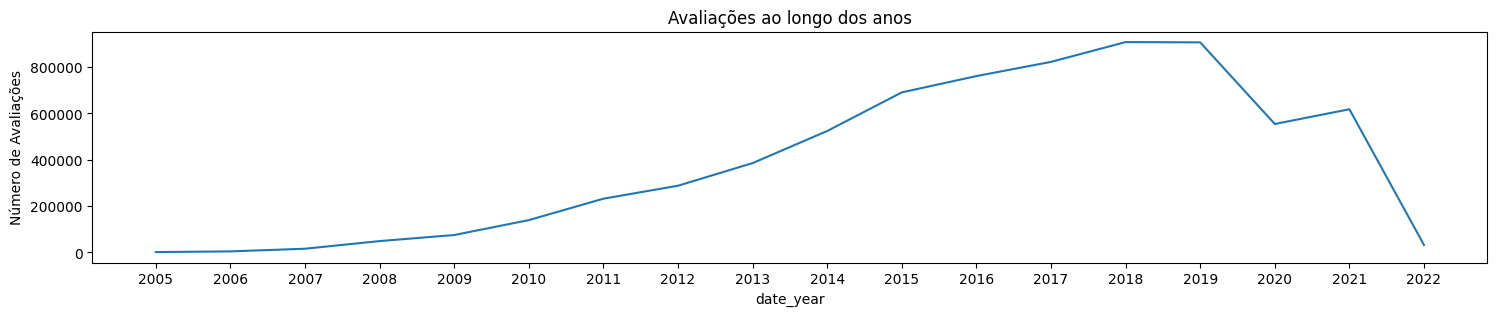

In [33]:
plt.figure(figsize=(18,3))
sns.lineplot(data=reviews_by_year, x='date_year', y='reviews_count')
plt.title('Avaliações ao longo dos anos')
plt.ylabel('Ano')
plt.ylabel('Número de Avaliações')
_ = plt.xticks(ticks=[i for i in range(2005,2023)])

Ao analisar o gráfico, vemos uma crescente nas avaliações. Em 2020 vemos uma queda vertiginosa e uma tendência decrescente desde então. Cabe atentar ao fato de que a quantidade de reviews pode estar atrelada às visitas físicas aos estabelecimentos, que foram severamente comprometidas com a pandemia de Covid-19. Sendo os dados disponíveis até parte de 2022, não conseguimos inferir se no período pós-pandemia houve uma nova crescente.

### Analisando a distribuição de estrelas

Ao contar a quantidade de avaliações com uma determinada nota, podemos entender melhor o significado das avaliações bem como identificar comportamentos dos usuários em relação à avaliação. 

In [12]:
connectionString = f'DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={SERVER.value};DATABASE={DATABASE.value};UID={USERNAME.value};PWD={PASSWORD.value}'
conn = pyodbc.connect(connectionString) 

cursor = conn.cursor()

query = '''
SELECT COUNT(*) AS reviews_count, stars
FROM jonnathan_costa_review jcr 
GROUP BY stars 
ORDER BY stars ASC; 

'''

cursor.execute(query)

rows = cursor.fetchall()

columns = [column[0] for column in cursor.description]

stars_distribution = pd.DataFrame.from_records(rows, columns=columns)

In [13]:
stars_distribution.head()

,reviews_count,stars
0,1071380,1
1,545544,2
2,693854,3
3,1457289,4
4,3239162,5


Text(0, 0.5, 'Número de Avaliações')

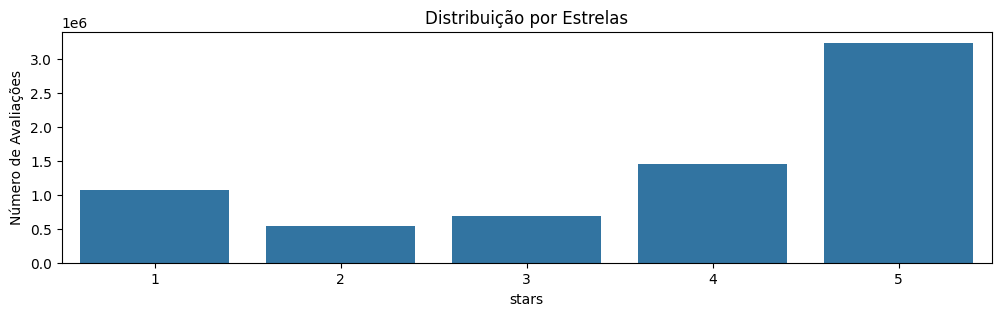

In [17]:
plt.figure(figsize=(12,3))
sns.barplot(data=stars_distribution, x='stars', y='reviews_count')
plt.title('Distribuição por Estrelas')
plt.ylabel('Número de Avaliações')

Sobre a distribuição de estrelas, vemos uma forte presença de avaliações de 1 estrela. Isso pode se dar devido ao possível caráter subjetivo de atribuir apenas uma estrela à um mserviço que não lhe agrada, lê-se, idependente se o serviço foi pouco ineficiente ou muito desagradável, a opção por atribuir 1 estrela parece atrair os avaliadores mais do que 2 ou 3. Note que a as três opções de nota mais comuns são 5, 4 e 1 estrela. 

### Análise de sentimento usando Vader

In [ ]:
import nltk
nltk.download('vader_lexicon')

In [20]:
import math
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [15]:
connectionString = f'DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={SERVER.value};DATABASE={DATABASE.value};UID={USERNAME.value};PWD={PASSWORD.value}'
conn = pyodbc.connect(connectionString) 

cursor = conn.cursor()

query = '''
SELECT text, stars
FROM jonnathan_costa_review
'''

cursor.execute(query)

rows = cursor.fetchall()

columns = [column[0] for column in cursor.description]

reviews = pd.DataFrame.from_records(rows, columns=columns)

Para entender a correlação entre estrelas e o score atribuído aos comentários sobre a empresa, selecionamos 10% dos dados de forma aletória, e vamos atribuir um score para cada comentário usando o analyzer.

Vamos mapear o score do comentário para que o score esteja entre 1 e 5 como as estrelas, plotar os gráficos lado a lado e calcular a correlação entre as variáveis stars e score.

In [16]:
reviews_10_percent = reviews.sample(frac=0.1, axis=0)

In [21]:
reviews_10_percent['score'] = reviews_10_percent['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [22]:
reviews_10_percent.head()

,text,stars,score
349560,Our 1st visit there and it was amazing. It wil...,5,0.7088
4849591,"I love the big rink, friendly knowledgeable an...",5,0.9360
5170204,We eat here all.the.time and it's super delish...,4,0.9037
450378,I have been shopping with Linda's Stuff for ye...,5,0.6222
2609878,"We drove by and saw the ""now open"" sign. I was...",4,0.8932


In [23]:
#função de um mapa linear do score do comentário de [-1,1] para [1,5] para que o intervalo seja igual e possamos comparar com clareza
def score_to_star(score):
    return math.floor(2.5*score + 3.5)

In [24]:
score = reviews_10_percent.score
score = score.apply(score_to_star) 

#### Comparação da distribuição de scores e stars

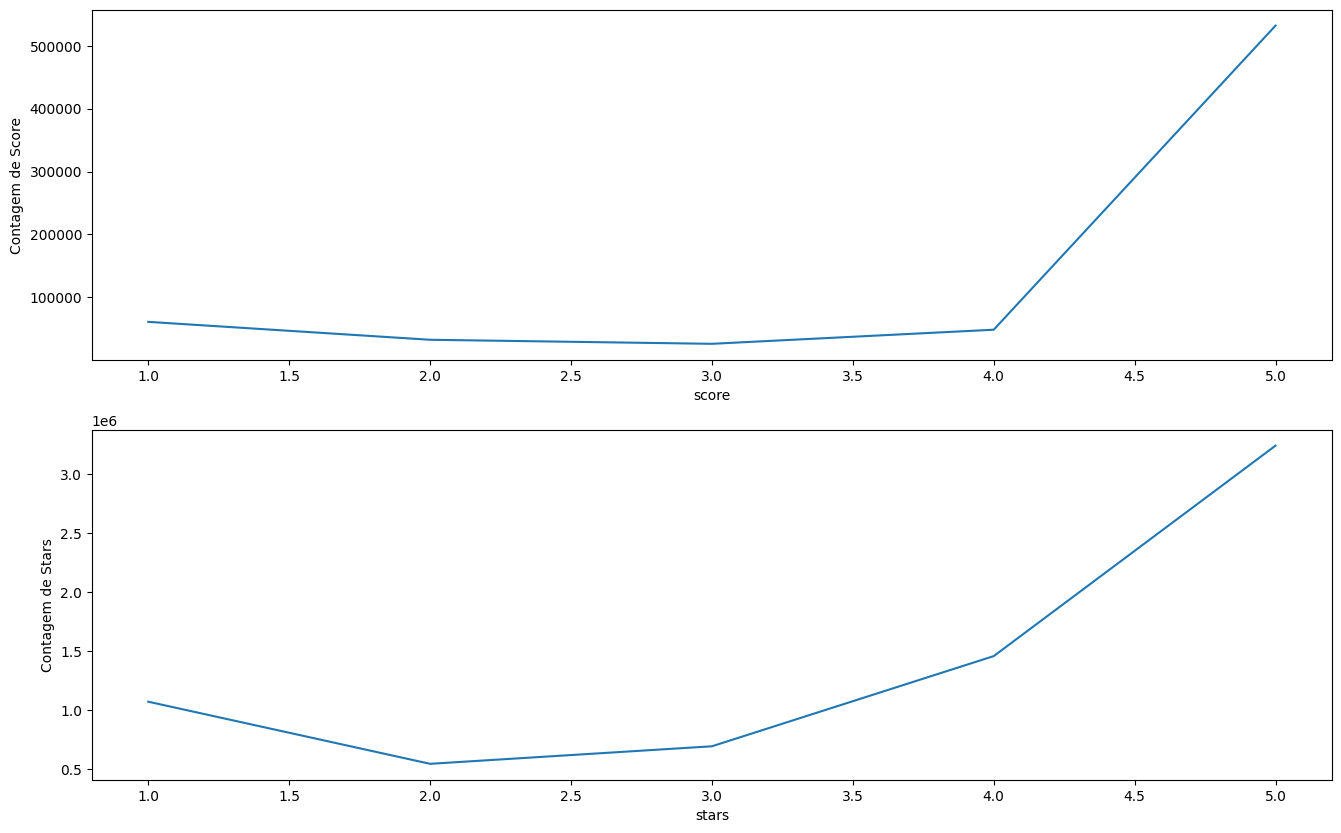

In [43]:
plt.subplots(2, 1, figsize=(16, 10))

plt.subplot(2,1,1)
sns.lineplot(data=score.value_counts())
_ = plt.ylabel('Contagem de Score')

plt.subplot(2,1,2)
sns.lineplot(data=stars_distribution, x='stars', y='reviews_count')
_ = plt.ylabel('Contagem de Stars')

plt.show()

Text(0.5, 1.0, 'Correlação entre Stars e Scores')

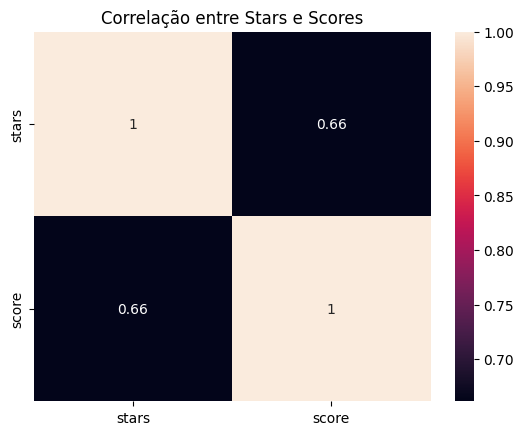

In [30]:
sns.heatmap(reviews_10_percent.corr(numeric_only=True), annot=True)
plt.title('Correlação entre Stars e Scores')

Supondo a eficiência das ferramentas da biblioteca Vader, podemos ver que existe uma coerência nos reviews escritos quando relacionados com as estrelas dadas pelos usuários. Uma nota alta tem uma alta correlação positiva com um comentário positivo, como era de se esperar. Podemos notar isso também ao olhar para a distribuição de estrelas vs. a distribuição das notas atribuídas aos comentários. 